In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx import *
from numba import njit
import warnings
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from numba import NumbaPendingDeprecationWarning

In [21]:
''' Functions '''
path = r'download.tsv.subelj_euroroad/subelj_euroroad/datos.txt'

def load_data(path):
    # Load the data

    df = pd.read_csv(path, delimiter=' ')

    # Reset the index to get a DataFrame with a column 'index' containing the old index values
    new_df = df.reset_index()

    # Create the edge list DataFrame
    edge_list_df = new_df[['index', '%']]

    edge_list_df.loc[0, 'index'] = 0

    # Treat the data as numbers
    edge_list_df['index'] = pd.to_numeric(edge_list_df['index'])

    edge_list = list(zip(edge_list_df['index']-1 ,edge_list_df['%']-1))
    edge_list = edge_list[1:]
    edge_list = np.asarray(edge_list)
    return edge_list


# Find the total nodes and links of the network
def find_nodes_edges(edge_list):
    # Compute the total number of nodes
    # A +1 is added to count node 0
    nodes = max(max(edge) for edge in edge_list) +1

    # Compute the total number of links
    links = len(edge_list)

    return nodes, links

# Find the degree list 
@njit
def find_K(edge_list, nodes):
    # Given an edge list in tuple format
    # Find the degree of each node

    '''
    Nodes MUST start at node 0. The edge list must be a NUMPY ARRAY
    
    K : Degree of nodes (np.array dtype int)
    
    '''
    aux_k = np.zeros(nodes, dtype='int')

    for edge in edge_list:
        # Increment the degree of each node for every edge 
        aux_k[edge[0]] += 1
        aux_k[edge[1]] += 1 

    return aux_k

# Find the first neighbours list
@njit
def FN_array(nodes, links, edge_list, K):

    Read = np.zeros(nodes, dtype='int')
    FN = np.zeros(2 * links, dtype='int')
    '''

    FN : NN list (np.array dtype int)
    
    '''
    for edge in edge_list:
        # Read left part of the edge
        FN[ np.sum(K[:edge[0]]) + Read[edge[0]]  ] = edge[1]
        Read[edge[0]] +=1

        # Read right part of the edge
        FN[ np.sum(K[:edge[1]]) + Read[edge[1]]  ] = edge[0]
        Read[edge[1]] += 1
    return FN

@njit
def select_nn(FN, K,  j):
        return FN[ sum(K[:j]) : sum(K[:j]) + K[j] ]

def inicializar_nodos(N, seed):
    if seed==True:
        np.random.seed(4)
        return np.random.randint(0, 2, N)
    else:
        return np.random.randint(0, 2, N)

''' SIS ALGORITHM '''
#@njit
def SIS(iter_loop, total_nodes, FN,K, la, delta, seed):


    Probs = [0,0] 
    '''
    Probs = number of [ infected NN, Infected nodes ]
    '''

    final_time= -8

    # Storage arrays
    time = np.zeros(iter_loop)
    infectaos = np.zeros(iter_loop)

    # Random inizialization of infected nodes. If seed=True, we use seed on the random numbers
    node_list = inicializar_nodos(total_nodes+1, seed)

    # Infected nodes list index
    inf =  np.where(node_list == 1)[0]

    # Calculo los nodos en riesgo, osea, los nodos que son S pero tienen primeros vecinos infectados
    # Y cuántos primeros vecinos infectados tienen
    riesgo = np.zeros(total_nodes+1)

    # Remember infected nodes also present risks
    for aux in range(total_nodes+1):
        aux_nn = select_nn(FN, K, aux )
        riesgo[aux] = len(set(aux_nn).intersection(set(inf)))

    # Ordenamos los nodos según 4 categorías
    # C = 0 (infectado sin vecinos infectados   i---->s    p=delta)
    #C=1 (infectado con vecinos infectados   i---->a    p=delta)
    #C=2 (sano con vecinos infectados        a---->i    p=n_i*lambda)
    #C=3 (sano sin vecinos infectados        s---->a    p=0)


    # Classifying array
    C = np.zeros(total_nodes+1)

    # Transition rates per classification
    mu = [delta, delta, la, 0]

    # Probability array
    ''' 
    Probs[0] =  se infecta =  lambda * num_activos * nn_infectados
    Probs[1] = se cura = delta * num_infectados
    '''
    for i in range(total_nodes+1):
        if i in inf:
            if riesgo[i]==0:
                C[i] = 0
            else:
                C[i] = 1 
            Probs[1]+=1
        else:
            if riesgo[i] ==0:
                C[i] = 3
            else:
                C[i] = 2
                # Add nn 
                Probs[0] += riesgo[i]

    infectaos[0]=Probs[1]
    
    # Start of Guillespie
    for i in range(1, iter_loop):
        # Control 
        if i%50000==0:
            print(f'iter: {i}')
        
        # Sum of all probabilities
        a_0 = Probs[1]*delta + Probs[0]*la

        if a_0 ==0:

            final_time = time[i-1]
            time= time[:i+1]
            infectaos= infectaos[:i+1]
            break

        # Random time step
        rand_time = np.random.uniform(0,1)
        tau = -np.log(rand_time)/a_0

        
        # Select the changing node
        changing_node = total_nodes + 5
        cumsum = 0
        
        while (changing_node== total_nodes+5)==True:
            aux_num  = np.random.uniform(0, a_0)
            for m in range(total_nodes+1):
                
                if C[m] ==2:
                    cumsum+= la*riesgo[m]
                else:
                    cumsum+= mu[int(C[m])]
                if int(aux_num) <= cumsum:
                    changing_node = m
                    break

        # Change conexions of the selected node

        # Si C[0]:
        if C[changing_node] == 0:
            C[changing_node]= 3
            # One less infected node
            Probs[1] -=1

            # Change active nodes list
            nn = select_nn(FN, K, changing_node) 
       
            Probs[0] -= len(nn)
            riesgo[nn] -=1
            # Change neighbors class
            for aux in nn:
                if C[aux]==2 and riesgo[aux]==0:
                    C[aux]=3
                if C[aux]==1 and riesgo[aux]==0:
                    C[aux]=0

        elif C[changing_node] == 1:
            C[changing_node]= 2
            # One less infected node
            Probs[1] -=1
            # Change active nodes list
            nn = select_nn(FN, K, changing_node)

            Probs[0] -= (len(nn)-riesgo[changing_node])
            Probs[0] += riesgo[changing_node]
            riesgo[nn] -=1
            # Change neighbors class
            for aux in nn:
                if C[aux]==1:
                    if riesgo[aux]==0:
                        C[aux]=0
                if C[aux]==2:
                    if riesgo[aux]==0:
                        C[aux]=3


        elif C[changing_node] == 2:
            C[changing_node]= 1
            
            nn = select_nn(FN, K, changing_node)
             # One more infected node
            Probs[1] +=1
    
            Probs[0] -= riesgo[changing_node]
            Probs[0]+=(len(nn)-riesgo[changing_node])
            riesgo[nn] +=1

            # Change neighbors class
            for aux in nn:
                if C[aux]==0:
                        C[aux]=1
                if C[aux]==3:
                        C[aux]=2
                        
               
        infectaos[i] = Probs[1]
        time[i] = time[i-1]+ tau


    return time, final_time, infectaos

# pruning to find out the average of the last values
def retain_non_zero_values(array, time):
    """
    Retains only the non-zero values from the input array.

    Parameters:
    - array: numpy array

    Returns:
    - A numpy array containing only the non-zero values of the input array.
    """
    # Use boolean indexing to filter out the non-zero values
    non_zero_values = array[array != 0]
    if len(non_zero_values) > 0:
        last_non_zero_index = np.max(np.nonzero(array))
    else:
        last_non_zero_index = None
    
    time_new = time[:last_non_zero_index+1]
    return non_zero_values, time_new


def generate_configuration_model(degree_sequence):
    while True:
        # Verifying if the sequence of degrees is valid
        if np.sum(degree_sequence) % 2 != 0:
            raise ValueError("The sum of the degrees must be even")

        # List of nodes replicated by their degrees
        stub_list = []
        for node, degree in enumerate(degree_sequence):
            stub_list.extend([node] * degree)

        # List of edges
        edges = []

        # Random connections
        random.shuffle(stub_list)

        # Linking the nodes
        while len(stub_list) > 1:
            u = stub_list.pop()
            v = stub_list.pop()

            if u != v:
                edges.append((u, v))
            else:
                # Neglecting the loops
                stub_list.append(u)
                random.shuffle(stub_list)

        # Verifying if there is no linked nodes
        if len(stub_list) == 1:
            continue  # Retry generating the graph

        return edges
def find_last_values(array):
    if array[-1]==1:
        return 1
    else:
        aux = array[-100:]
        return np.mean(aux)

Statistics of the network and theoretical $\lambda_c$

In [8]:
edge_list = load_data(path)
total_nodes, total_links = find_nodes_edges(edge_list)
K=  find_K(edge_list,total_nodes )
FN = FN_array(total_nodes, total_links, edge_list, K)
print('average degree: ', np.average(K))

lc= np.mean(K)/np.mean(K**2)
print(r'Theoretical $\lambda_c$ ', lc)

C:\Users\irene\AppData\Local\Temp\ipykernel_12748\1714529412.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_list_df['index'] = pd.to_numeric(edge_list_df['index'])


average degree:  2.41396933560477
Theoretical $\lambda_c$  0.33341176470588235


Explaining of the SIS algorithm:

Each node is classified in either Infected (I), cured (S) or in risk (A). When chaging a node we can have these 4 processes with different rates: 

1. S->S without infected neighbors. Rate= 0 \
2. S->I with infected neighbors. Rate= $nn*\lambda$
3. I->S with infected neighbors. Cured by chance. Rate=$\delta$
4. I->S without infected neighbors. Rate=$\delta$

Guillespie algorithm chooses by a weighted probability which node will change and when will it take place. There are a fixed number of iterations of the algorithm, however it may end before when all nodes are cured. Iterations are chosen so that a plateau is acchieved if not all nodes are cured. 

In [9]:
# Choose different values in regards to lambda_c
lam = [0.5,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,3,5,50,500]


times = [0]*len(lam)
infected = [0]*len(lam)

iter= 20000

for i in range(len(lam)):
    t, ft, inf = SIS(iter, total_nodes, FN, K , lam[i]*lc, 1,True)
    times[i] = t
    infected[i] = inf



(0.0, 25.0)

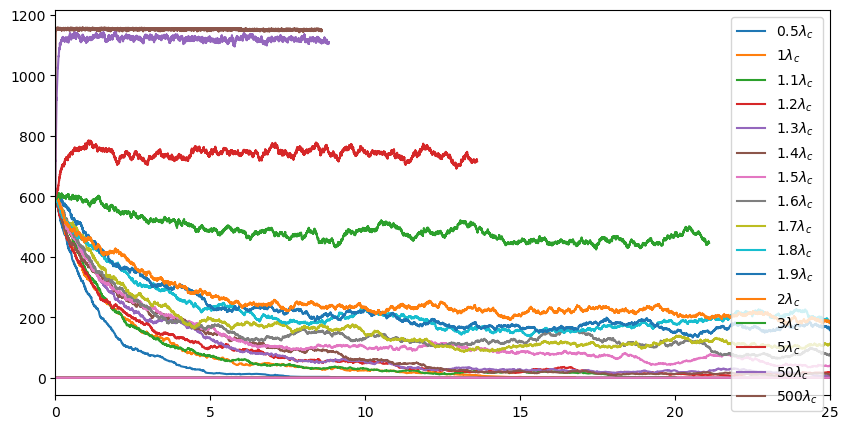

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(len(lam)):
    plt.plot(times[i], infected[i], label=f'{lam[i]}'+r'$\lambda_c$')
plt.legend()
plt.xlim([0,25])

In [11]:
# Ditch 0 values of lambdas in which the simulation ends
copy_infected = [0]*len(lam)
copy_times = [0]*len(lam)
average = [0]*len(lam)

for i in range(len(lam)):
    copy_infected[i], copy_times[i] = retain_non_zero_values(infected[i], times[i])


# Plot some representative lambdas

selected = [0.5, 1, 3, 5, 50,500]
lam_array = np.asarray(lam)
index = [0]*len(selected)

for i in range(len(selected)):
    index[i] = np.where(lam_array== selected[i])[0][0]


## TIME EVOLUTION OF THE INFECTION PER ORDER PARAMETER

(0.0, 15.0)

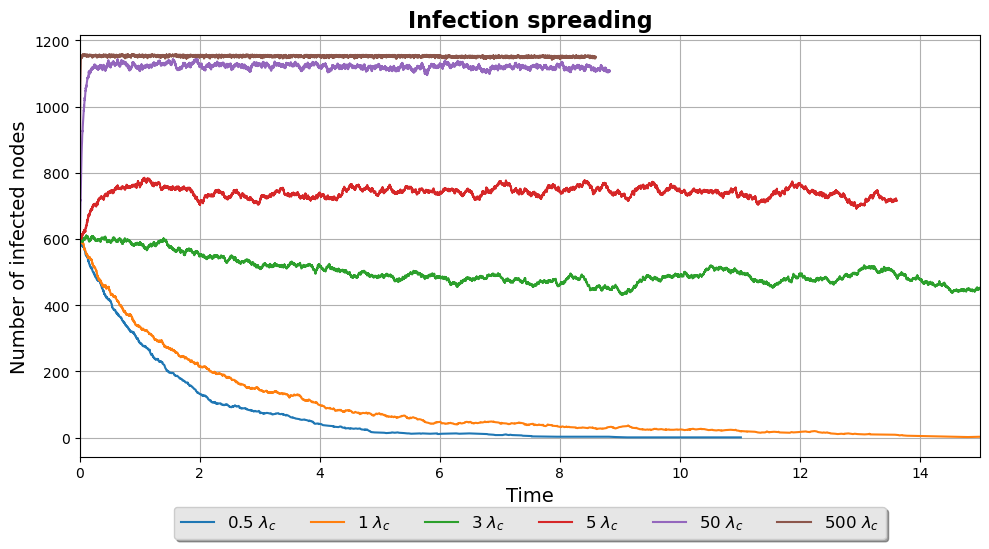

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
for i,ind in enumerate(index):
    plt.plot(copy_times[ind], copy_infected[ind], label=f'{selected[i]} '+r'$\lambda_c$')
    
# Set plot title and labels
ax.set_title('Infection spreading', fontsize=16, fontweight = 'bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Number of infected nodes', fontsize=14)

# Add grid
ax.grid(True)

# Add legend below the plot with a shaded box
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(selected), fontsize=12)

# Add shaded background to legend
frame = legend.get_frame()
frame.set_facecolor('0.90')  # Light gray

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
ax.set_xlim([0,15])

## TIME EVOLUTION NEAR $\lambda_c$

(0.0, 30.0)

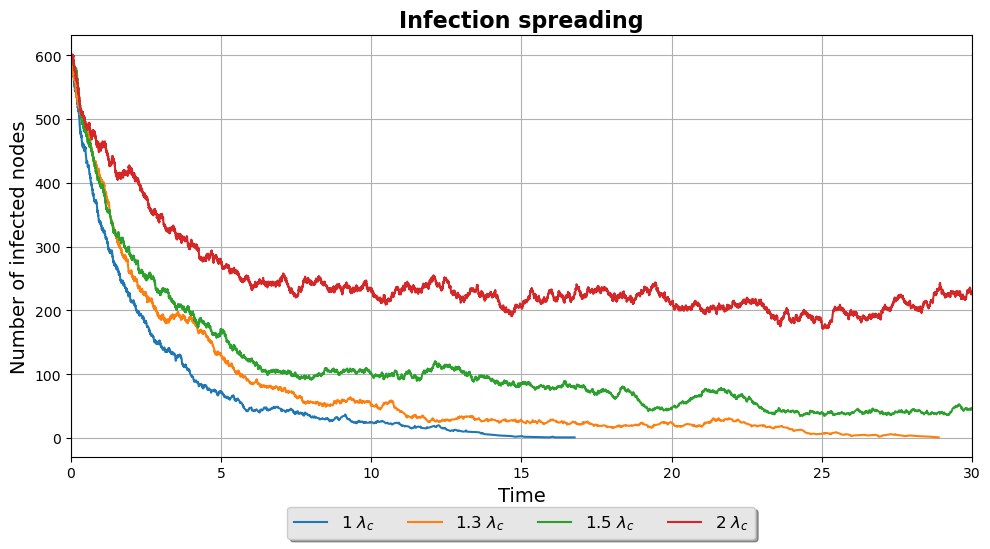

In [13]:
near_lc = [1,1.3,1.5,2]


near_array = np.asarray(lam)
near_index = [0]*len(near_lc)

for i in range(len(near_lc)):
    near_index[i] = np.where(lam_array== near_lc[i])[0][0]

fig, ax = plt.subplots(figsize=(10, 6))
for i,ind in enumerate(near_index):
    plt.plot(copy_times[ind], copy_infected[ind], label=f'{near_lc[i]} '+r'$\lambda_c$')

# Set plot title and labels
ax.set_title('Infection spreading', fontsize=16, fontweight = 'bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Number of infected nodes', fontsize=14)

# Add grid
ax.grid(True)

# Add legend below the plot with a shaded box
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(selected), fontsize=12)

# Add shaded background to legend
frame = legend.get_frame()
frame.set_facecolor('0.90')  # Light gray

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
ax.set_xlim([0,30])

## CRITICALITY

We average the plateaus in order to find the number of infected nodes. We plot the number of infected nodes vs the order parameter

In [22]:
# Last values vs lambda

for i in range(len(copy_infected)):
    average[i] = find_last_values(copy_infected[i])



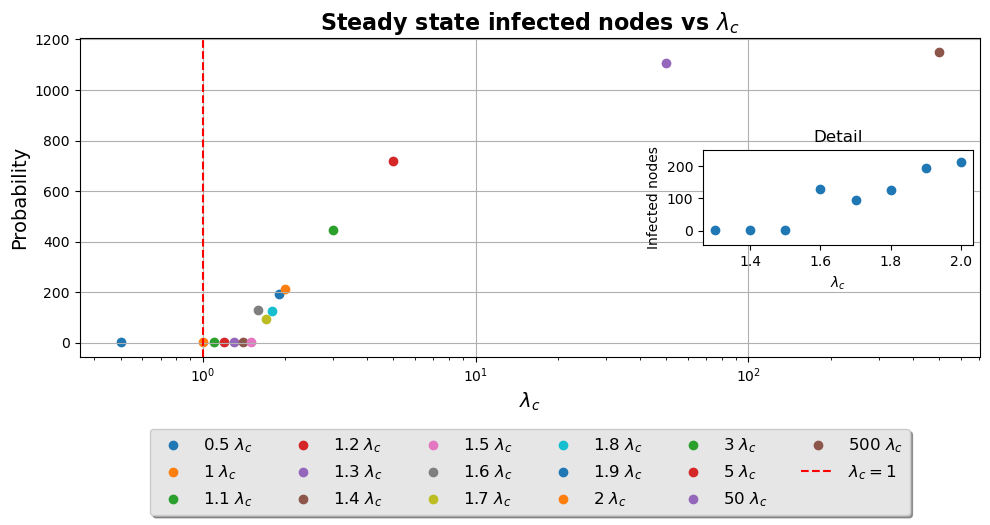

In [37]:

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(copy_infected)):   
    plt.scatter(lam[i], average[i], label=f'{lam[i]} '+r'$\lambda_c$')
plt.xscale('log')
plt.axvline(x=1, color='r', linestyle='--', label=f'$\lambda_c = {1}$')
# Set plot title and labels
ax.set_title('Steady state infected nodes vs '+r'$\lambda_c$', fontsize=16, fontweight = 'bold')
ax.set_xlabel(r'$\lambda_c$', fontsize=14)
ax.set_ylabel('Steady state infected nodes', fontsize=14)
# Add legend below the plot with a shaded box
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=len(selected), fontsize=12)

# Add shaded background to legend
frame = legend.get_frame()
frame.set_facecolor('0.90')  # Light gray

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.97])


inset_ax = inset_axes(ax, width="30%", height="30%", loc='center right')
inset_ax.scatter(lam[4:12], average[4:12])
inset_ax.set_title('Detail')
inset_ax.set_ylabel('Infected nodes')
inset_ax.set_xlabel(r'$\lambda_c$')
inset_ax.set_ylim([-45,250])
# Add grid
ax.grid(True)

## CRITICALITY AFTER MAKING A REWIRING

In [27]:
# Now try rewiring a looking at the same thing

rewirings = 1

new_edges = generate_configuration_model(K)
new_fn = FN_array(total_nodes, total_links, new_edges, K)


In [28]:

new_times = [0]*len(lam) 
new_infected = [0]*len(lam)

for i in range(len(lam)):
    new_times[i], ft, new_infected[i] = SIS(iter, total_nodes, new_fn, K , lam[i]*lc, 1,True)

# Ditch zero values should the network cures itself
for i in range(len(lam)):
    new_infected[i], new_times[i] = retain_non_zero_values(new_infected[i], new_times[i])

new_averages = [0]*len(lam) 

for i in range(len(new_infected)):
    new_averages[i] = find_last_values(new_infected[i])

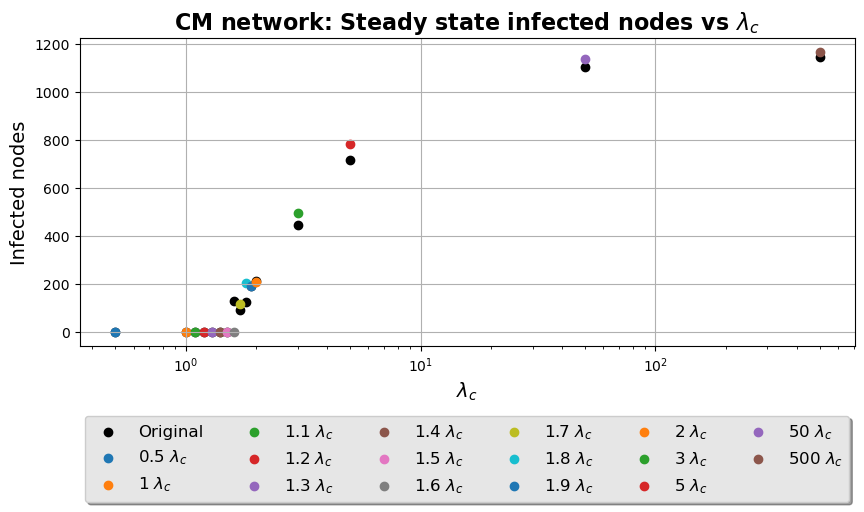

In [34]:

fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(lam, average, color='black', label='Original')
for i in range(len(new_infected)):   
    plt.scatter(lam[i], new_averages[i], label=f'{lam[i]} '+r'$\lambda_c$')
plt.xscale('log')
plt.xlabel(r'$\lambda_c$', fontsize=14)
plt.ylabel('Infected nodes', fontsize=14)

plt.title('CM network: Steady state infected nodes vs '+r'$\lambda_c$', fontsize=16, fontweight = 'bold')
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=len(selected), fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('0.90')  # Light gray

# Add grid
ax.grid(True)

We suspect 1.6 times the theoretical value of $\lambda_c$ is the real critical value. In the critical value the system fluctuates endelessly and does not settle either on a plateau of infected nodes or converges and all nodes are cured. To show this we repeat the simulation 200 times with the network and its CM variant and do a histogram of how many times the SIS converges, ends up on 0 infected nodes, or it reaches a plateau. 

In [133]:

repes = 200
lambda_quasi = 1.6*lc

final_vals = [0]*repes
final_vals_rew = [0]*repes

for i in range(repes):
    tc, ft, infs = SIS(30000, total_nodes, FN, K, lambda_quasi, 1, False)
    rc, rt, rinfs = SIS(30000, total_nodes, new_fn, K, lambda_quasi, 1, False)
    final_vals[i] = infs[-1]
    final_vals_rew[i] = rinfs[-1]
    print(f'reps {i}')


reps 0
reps 1
reps 2
reps 3
reps 4
reps 5
reps 6
reps 7
reps 8
reps 9
reps 10
reps 11
reps 12
reps 13
reps 14
reps 15
reps 16
reps 17
reps 18
reps 19
reps 20
reps 21
reps 22
reps 23
reps 24
reps 25
reps 26
reps 27
reps 28
reps 29
reps 30
reps 31
reps 32
reps 33
reps 34
reps 35
reps 36
reps 37
reps 38
reps 39
reps 40
reps 41
reps 42
reps 43
reps 44
reps 45
reps 46
reps 47
reps 48
reps 49
reps 50
reps 51
reps 52
reps 53
reps 54
reps 55
reps 56
reps 57
reps 58
reps 59
reps 60
reps 61
reps 62
reps 63
reps 64
reps 65
reps 66
reps 67
reps 68
reps 69
reps 70
reps 71
reps 72
reps 73
reps 74
reps 75
reps 76
reps 77
reps 78
reps 79
reps 80
reps 81
reps 82
reps 83
reps 84
reps 85
reps 86
reps 87
reps 88
reps 89
reps 90
reps 91
reps 92
reps 93
reps 94
reps 95
reps 96
reps 97
reps 98
reps 99
reps 100
reps 101
reps 102
reps 103
reps 104
reps 105
reps 106
reps 107
reps 108
reps 109
reps 110
reps 111
reps 112
reps 113
reps 114
reps 115
reps 116
reps 117
reps 118
reps 119
reps 120
reps 121
reps 122
rep

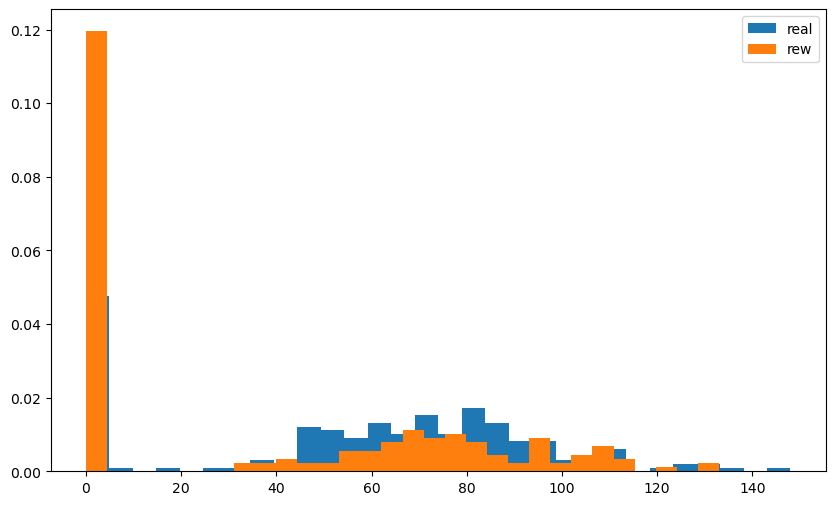

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(final_vals, density=True,bins=30,align='mid', label='real')

#fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = plt.hist(final_vals_rew,bins=30, density=True,align='mid', label='rew')
plt.legend()